In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [3]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
tgl = CVXInequalityTimeGraphicalLasso(max_iter=200, loss='LL', c_level=0.25, rho=1e1, psi="laplacian")
emp_inv_score, baseline_score, fit_score, pre_cvx = tgl.fit_cov(X_cov).eval_cov_pre() 

optimal
14.311561752595052


In [4]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return sum(map(l1_od_norm, Z_0)) + sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
for i in [1e-2, 1e-3, 1e-4, 1e-6]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][:1], psi))

412.4982891755868
452.20425831412996
453.81565873706984
453.87550135883754


In [8]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
res = {}
for i in [1., 2., 4.]:
    tgl = InequalityTimeGraphicalLasso(max_iter=2000, loss='LL', c_level=0.25, rho=1e2, div=i, psi="laplacian")
    res[i] = tgl.fit_cov(X_cov).eval_cov_pre() 

23 831.6089594927506
1.3563391094737272e-05 0.034199147228503604
0.0006781751564917978 0.02906329958918336
23 831.610632531674
1.3563391095981073e-05 0.03419914779170438
0.0006781751567300236 0.029063300569526294
23 831.6106325316739
1.3563391095965541e-05 0.03419914779170438
0.0006781751567300844 0.029063300569526294


In [70]:
from regain.covariance import InequalityTimeGraphicalLasso, TimeGraphicalLasso
tgl = InequalityTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.25, rho=100, theta=0.3, psi="laplacian")
emp_inv_score_grad, baseline_score_grad, fit_score_grad, pre_grad = tgl.fit_cov(X_cov).eval_cov_pre() 

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


208 344.59277890312836
0.00020247878291687496 0.03410362134535636
0.028777785206070917 0.028870801652278413


In [7]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1e1, tol=1e-4,
            rtol=1e-4, psi='laplacian', gamma=None, constrained_to=None, 
            max_iter=2000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

In [ ]:
%debug

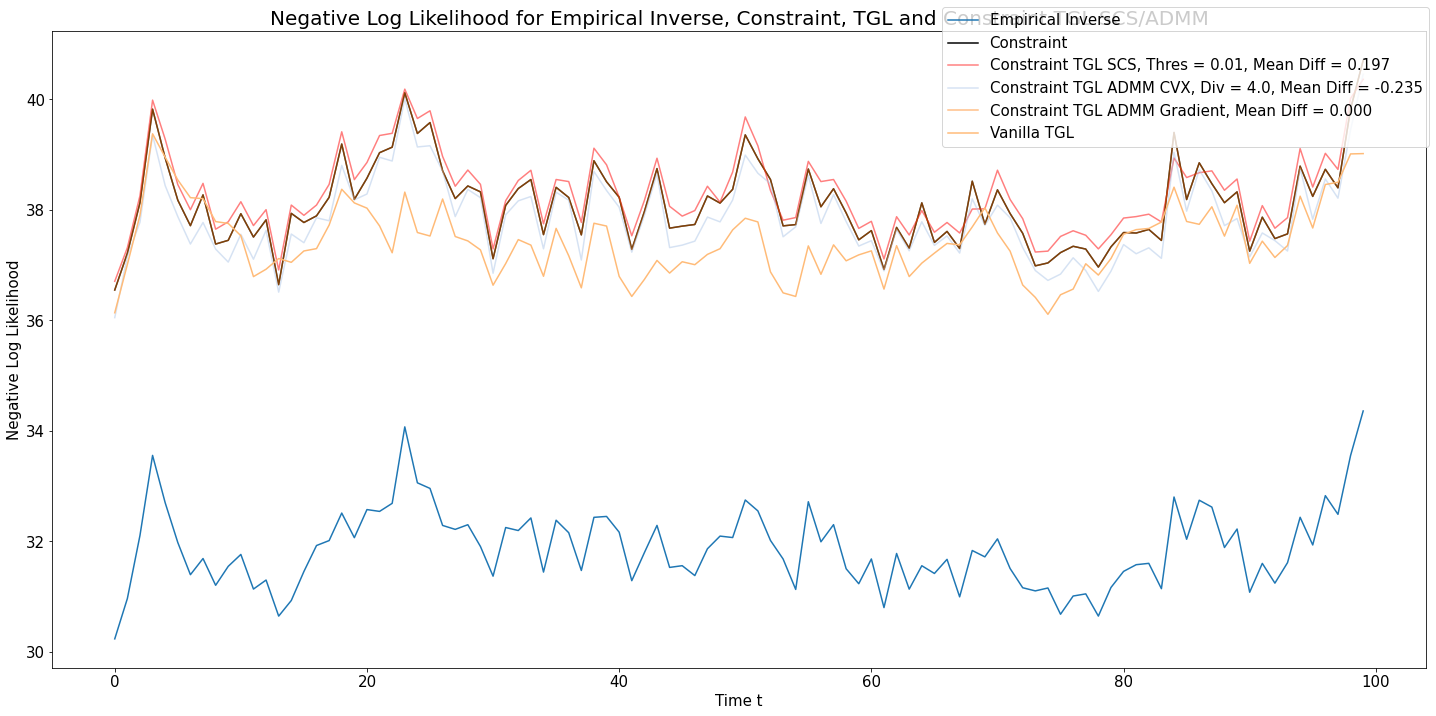

In [71]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), res[1][0], label=r'Empirical Inverse')
ax.plot(range(n_time), res[1][1], color='black', label=r'Constraint')
for i in [1e-2]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(n_time), fit_score[i], color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
for i in [4.]:    
    mean_diff = np.mean(np.array(res[i][2]) - res[i][1])
    ax.plot(range(n_time), res[i][2], alpha=0.5,
            label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
# mean_diff = np.mean(np.array(fit_score_diff) - baseline_score)
# ax.plot(range(n_time), fit_score_diff, alpha=0.5,
#         label=r'Constraint TGL ADMM Difference, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
ax.plot(range(n_time), fit_score_grad, alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
ax.plot(range(n_time), fit_score_, label=r'Vanilla TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('diff_like_{}_{}_admm.pdf'.format(dim_X, dim_fac))

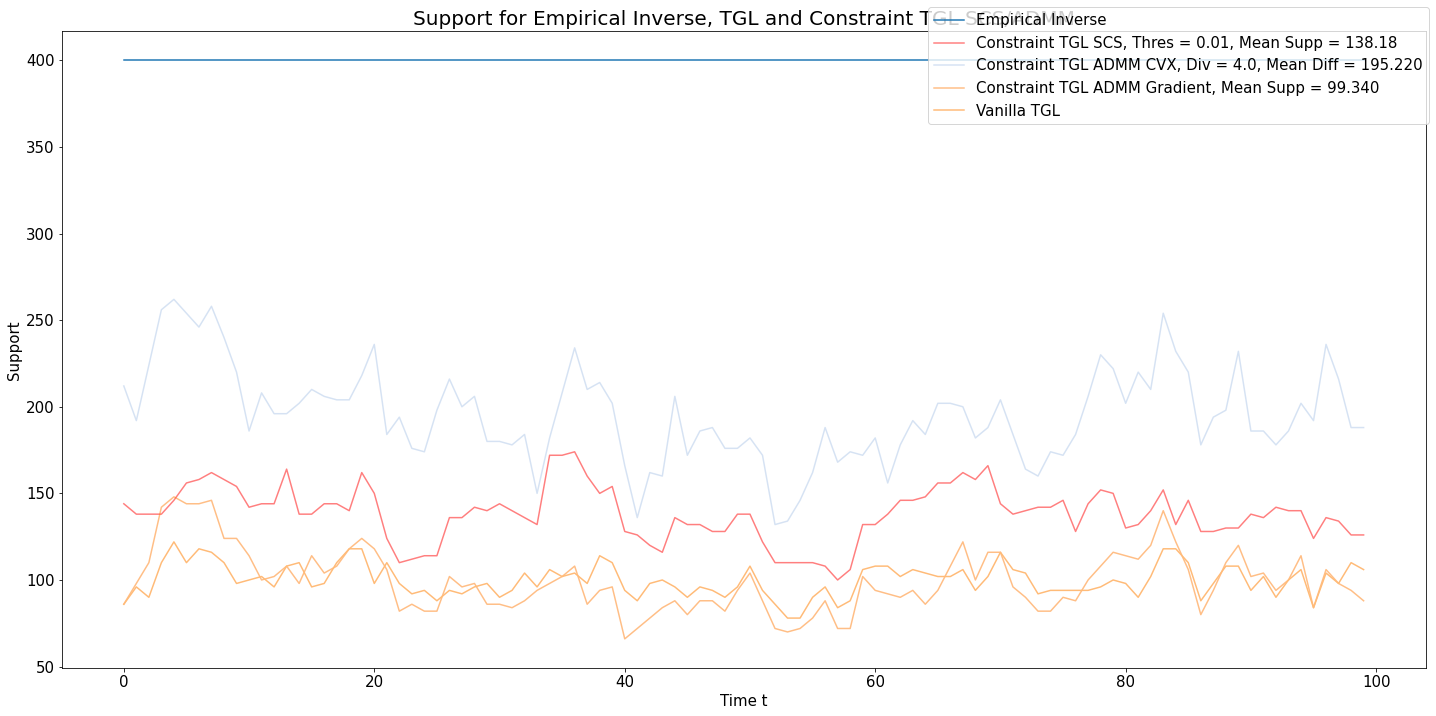

In [72]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0

ax.plot(range(n_time), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(n_time)], label=r'Empirical Inverse')
for i in [1e-2]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(n_time)]
    mean_supp = np.mean(supp)
    ax.plot(range(n_time), supp, color='r', alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
for i in [4.]:    
    supp = [sum(sum(abs(res[i][3][t]) > 0)) for t in range(n_time)]
    mean_supp = np.mean(supp)
    ax.plot(range(n_time), supp, alpha=0.5,
            label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, mean_supp))
# supp = [sum(sum(abs(pre_cvx[t]) > 0)) for t in range(n_time)]
# ax.plot(range(n_time), supp, alpha=0.5,
#         label=r'Constraint TGL ADMM CVX, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_diff[t]) > 0)) for t in range(n_time)]
# ax.plot(range(n_time), supp, alpha=0.5,
#         label=r'Constraint TGL ADMM Difference, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(n_time)]
ax.plot(range(n_time), supp, alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
ax.plot(range(n_time), [sum(sum(abs(pre_[k]) > 0)) for k in range(n_time)], label=r'Vanilla TGL')


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('diff_supp_{}_{}_admm.pdf'.format(dim_X, dim_fac))

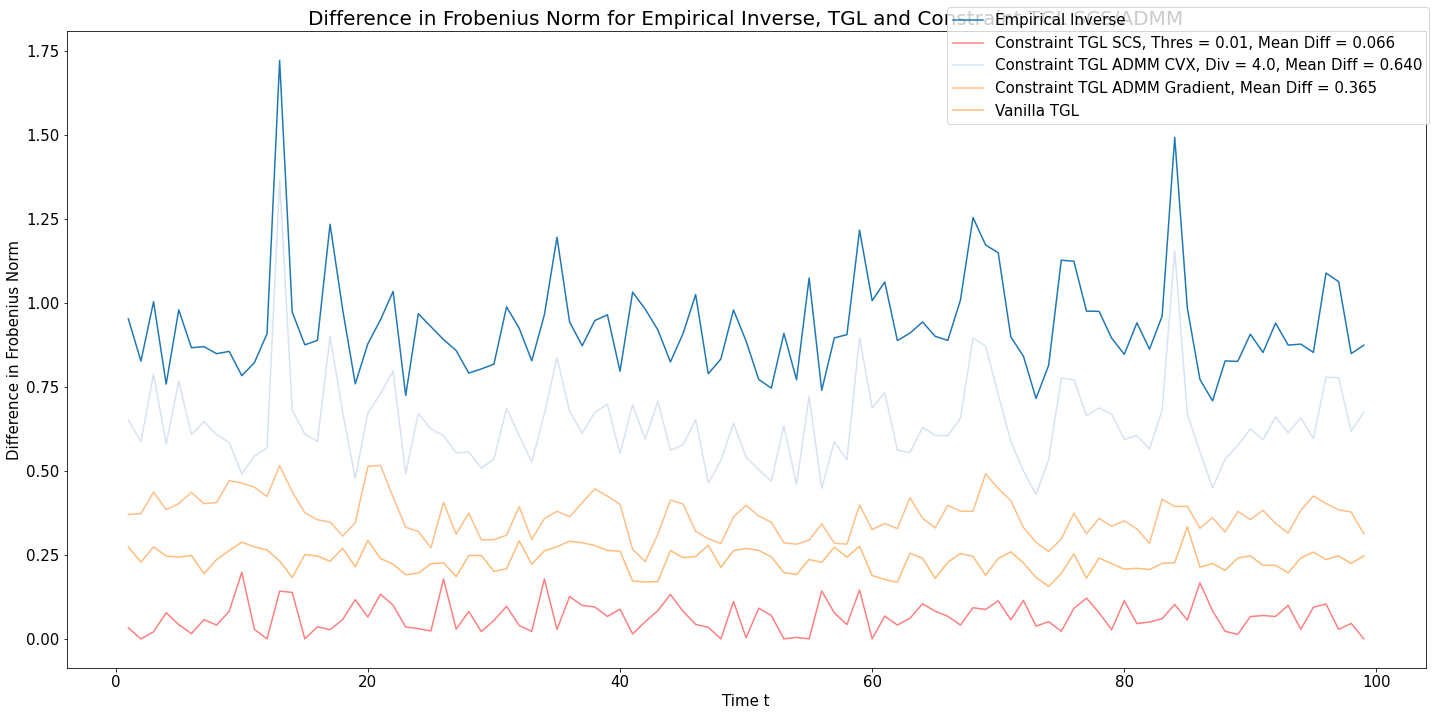

In [73]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgm"
color_index = 0


diff_emp = [norm(tgl.emp_inv[t] - tgl.emp_inv[t-1], 'fro') for t in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_emp), alpha=1, label=r'Empirical Inverse')
for i in [1e-2]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, 100)]
    mean_diff = np.mean(diff)
    ax.plot(range(1, n_time), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL SCS, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
for i in [4.]:    
    diff_cvx = [norm(res[i][3][t] - res[i][3][t-1], 'fro') for t in range(1, 100)]
    ax.plot(range(1, n_time), diff_cvx, alpha=0.5,
            label=r'Constraint TGL ADMM CVX, Div = {}, Mean Diff = {:.3f}'.format(i, np.mean(diff_cvx)))

# diff_cvx = [norm(pre_cvx[t] - pre_cvx[t-1], 'fro') for t in range(1, 100)]
# ax.plot(range(1, n_time), diff_cvx, alpha=0.5,
#         label=r'Constraint TGL ADMM CVX, Mean Diff = {:.3f}'.format(np.mean(diff_cvx)))
# diff_diff = [norm(pre_diff[t] - pre_diff[t-1], 'fro') for t in range(1, 100)]
# ax.plot(range(1, n_time), diff_diff, alpha=0.5,
#         label=r'Constraint TGL ADMM Difference, Mean Diff = {:.3f}'.format(np.mean(diff_diff)))
diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, 100)]
ax.plot(range(1, n_time), diff_grad, alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_fit_), alpha=1, label=r'Vanilla TGL')

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL SCS/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('diff_fro_{}_{}_admm.pdf'.format(dim_X, dim_fac))